In [1]:
print('hello world')

hello world


In [2]:
words = open('../names.txt', 'r').read().splitlines()
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [3]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
uniq=list(set(c for w in words for c in w))
uniq= uniq + ['.']
vocab=sorted(uniq)
stoi = {c:i for i,c in enumerate(vocab) }
itos = {i:s for s,i in stoi.items()}

In [5]:
vocab_len=len(vocab)
vocab_len

27

In [6]:
block_size=3
X,Y=[],[]
for w in words[:5]:
  context = [0]*block_size
  for ch in w+'.':
    X.append(context)
    Y.append(stoi[ch])
    print(f'{"".join(itos[c] for c in context)} --> {ch}')
    context = context[1:] + [stoi[ch]]

X=torch.tensor(X)
Y=torch.tensor(Y)

... --> e
..e --> m
.em --> m
emm --> a
mma --> .
... --> o
..o --> l
.ol --> i
oli --> v
liv --> i
ivi --> a
via --> .
... --> a
..a --> v
.av --> a
ava --> .
... --> i
..i --> s
.is --> a
isa --> b
sab --> e
abe --> l
bel --> l
ell --> a
lla --> .
... --> s
..s --> o
.so --> p
sop --> h
oph --> i
phi --> a
hia --> .


In [7]:
X.shape,Y.shape


(torch.Size([32, 3]), torch.Size([32]))

In [8]:
n_emb=2
C=torch.randn((vocab_len, 2))
C.shape

torch.Size([27, 2])

In [9]:
emb=C[X]
print(emb.shape)

emb[3], X[3], C[[5,13,13]]

torch.Size([32, 3, 2])


(tensor([[-0.2908, -0.3929],
         [-0.8274,  0.2596],
         [-0.8274,  0.2596]]),
 tensor([ 5, 13, 13]),
 tensor([[-0.2908, -0.3929],
         [-0.8274,  0.2596],
         [-0.8274,  0.2596]]))

In [10]:
n_neurons=100
W1 = torch.randn((block_size*n_emb, n_neurons))
b1 = torch.randn(n_neurons)
W1.shape, b1.shape



(torch.Size([6, 100]), torch.Size([100]))

In [11]:
W2 = torch.randn((n_neurons, vocab_len))
b2 = torch.randn(vocab_len)
W2.shape, b2.shape

(torch.Size([100, 27]), torch.Size([27]))

In [12]:
hpreact = emb.view(-1, block_size*n_emb) @ W1 + b1
h = torch.tanh(hpreact)
logits = h @ W2 + b2
probs =  F.softmax(logits, 1)

In [13]:
loss = F.cross_entropy(logits, Y)
loss

tensor(17.5956)

In [14]:
# train prep
n_emb=10
n_neurons=100
block_size=6

X,Y=[],[]
for w in words:
  context = [0]*block_size
  for ch in w+'.':
    X.append(context)
    Y.append(stoi[ch])
    #print(f'{"".join(itos[c] for c in context)} --> {ch}')
    context = context[1:] + [stoi[ch]]

X=torch.tensor(X)
Y=torch.tensor(Y)

g = torch.Generator().manual_seed(782361)

# init
C  = torch.randn((vocab_len, n_emb),            generator=g)
W1 = torch.randn((block_size*n_emb, n_neurons), generator=g) * ((5/3)/((block_size*n_emb)**0.5))
b1 = torch.randn(n_neurons,                     generator=g) * 0.001
W2 = torch.randn((n_neurons, vocab_len),        generator=g) * 0.01
b2 = torch.randn(vocab_len,                     generator=g) * 0.001

parameters = [C,W1,b1,W2,b2]
for p in parameters:
  p.requires_grad = True

In [15]:
((5/3)/((block_size*n_emb)**0.5))

0.21516574145596762

In [16]:
X.shape, Y.shape

(torch.Size([228146, 6]), torch.Size([228146]))

In [17]:
lossi = []

In [18]:
# train
lr = 0.1

for _ in range(10_000):
  # minibatch
  batch = torch.randint(0, X.shape[0], (64,), generator=g)

  # forward pass
  emb=C[X[batch]]
  hpreact = emb.view(-1, block_size*n_emb) @ W1 + b1
  h = torch.tanh(hpreact)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, Y[batch])
  
  # clear grads
  for p in parameters:
    p.grad = None
  # recompute grads
  loss.backward()
  # update
  for p in parameters:
    p.data += -lr * p.grad

  lossi.append(loss.item())
  break
loss

tensor(3.2914, grad_fn=<NllLossBackward0>)

(array([819., 336., 230., 211., 161., 119., 118., 106., 106.,  85.,  68.,
         96.,  80.,  58.,  75.,  59.,  85.,  67.,  65.,  83.,  59.,  50.,
         59.,  64.,  51.,  47.,  51.,  66.,  65.,  34.,  73.,  64.,  76.,
         86.,  62.,  86.,  56.,  52.,  74., 104.,  80.,  81., 120., 122.,
        123., 144., 177., 224., 270., 753.]),
 array([-9.99978423e-01, -9.59979054e-01, -9.19979684e-01, -8.79980315e-01,
        -8.39980946e-01, -7.99981576e-01, -7.59982207e-01, -7.19982837e-01,
        -6.79983468e-01, -6.39984099e-01, -5.99984729e-01, -5.59985360e-01,
        -5.19985991e-01, -4.79986621e-01, -4.39987252e-01, -3.99987882e-01,
        -3.59988513e-01, -3.19989144e-01, -2.79989774e-01, -2.39990405e-01,
        -1.99991035e-01, -1.59991666e-01, -1.19992297e-01, -7.99929273e-02,
        -3.99935579e-02,  5.81145287e-06,  4.00051808e-02,  8.00045502e-02,
         1.20003920e-01,  1.60003289e-01,  2.00002658e-01,  2.40002028e-01,
         2.80001397e-01,  3.20000767e-01,  3.60000

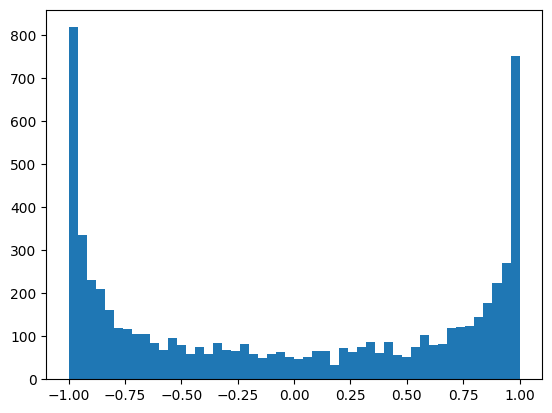

In [19]:
plt.hist(h.view(-1).tolist(), 50)

(array([  2.,   1.,   4.,   7.,  13.,  11.,  17.,  26.,  39.,  62.,  64.,
         76., 101., 114., 163., 128., 219., 250., 293., 294., 330., 328.,
        347., 365., 311., 376., 330., 309., 306., 267., 248., 178., 174.,
        158., 123., 104.,  68.,  54.,  29.,  34.,  24.,  16.,  10.,   4.,
          4.,   3.,   5.,   8.,   1.,   2.]),
 array([-5.71904135, -5.4825574 , -5.24607346, -5.00958951, -4.77310556,
        -4.53662162, -4.30013767, -4.06365373, -3.82716978, -3.59068583,
        -3.35420189, -3.11771794, -2.881234  , -2.64475005, -2.40826611,
        -2.17178216, -1.93529821, -1.69881427, -1.46233032, -1.22584638,
        -0.98936243, -0.75287848, -0.51639454, -0.27991059, -0.04342665,
         0.1930573 ,  0.42954124,  0.66602519,  0.90250914,  1.13899308,
         1.37547703,  1.61196097,  1.84844492,  2.08492887,  2.32141281,
         2.55789676,  2.7943807 ,  3.03086465,  3.26734859,  3.50383254,
         3.74031649,  3.97680043,  4.21328438,  4.44976832,  4.68625227,
 

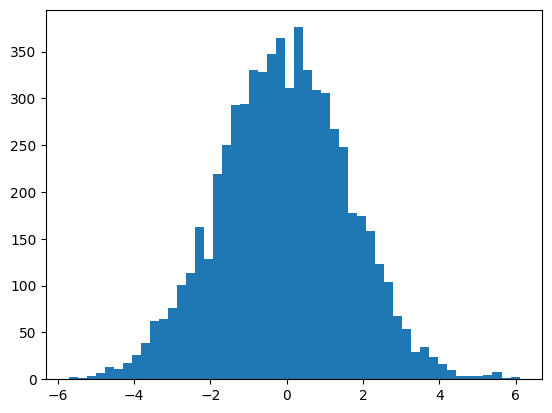

In [20]:
plt.hist(hpreact.view(-1).tolist(), 50)

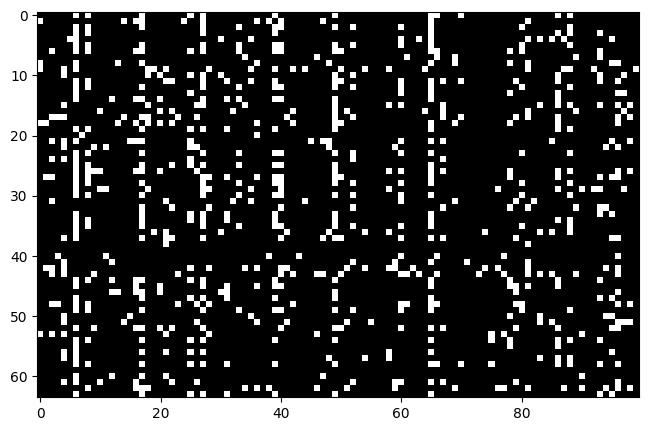

In [21]:
plt.figure(figsize=(10,5))
plt.imshow(h.abs() > 0.99, cmap='gray')

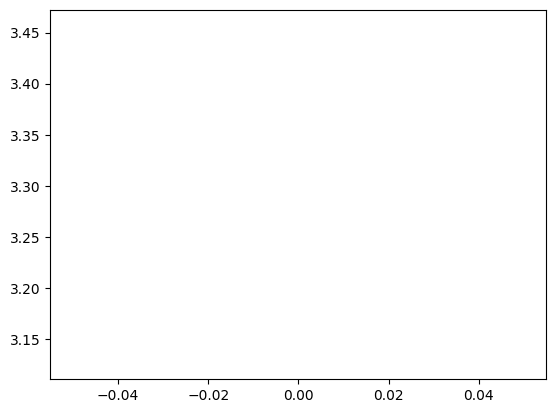

In [22]:
plt.plot(lossi)

In [23]:
# init estimate loss
-torch.tensor(1/vocab_len).log()

tensor(3.2958)

(array([  27.,  155.,  518., 1184., 1681., 1588.,  881.,  289.,   58.,
          19.]),
 array([-5.71904135, -4.53662162, -3.35420189, -2.17178216, -0.98936243,
         0.1930573 ,  1.37547703,  2.55789676,  3.74031649,  4.92273622,
         6.10515594]),
 <BarContainer object of 10 artists>)

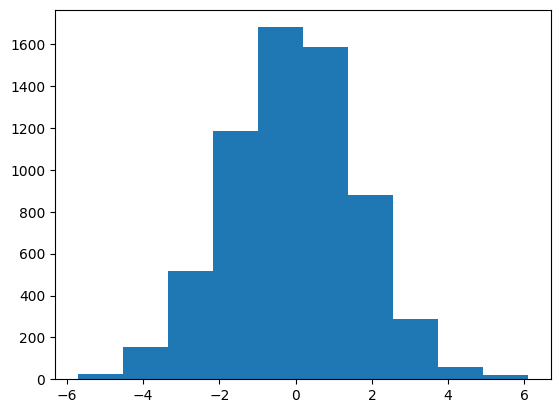

In [24]:
plt.hist(hpreact.view(-1).tolist())


(array([ 20.,  51., 106., 248., 292., 400., 297., 174., 109.,  31.]),
 array([-0.23115037, -0.18661439, -0.14207841, -0.09754243, -0.05300644,
        -0.00847046,  0.03606552,  0.0806015 ,  0.12513749,  0.16967347,
         0.21420945]),
 <BarContainer object of 10 artists>)

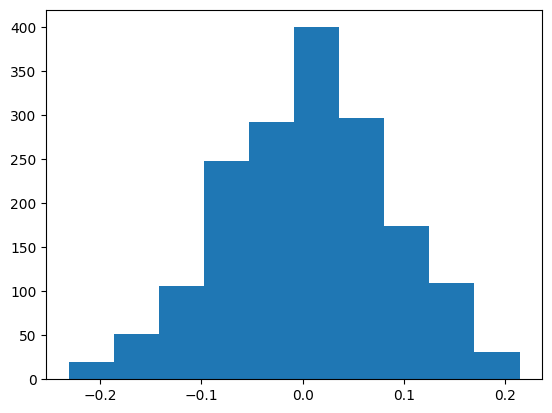

In [25]:
plt.hist(logits.view(-1).tolist())

In [26]:
# inference
out=[]
for i in range(5):
  out.append([])
  context = [0] * block_size
  while True:
    # forward pass
    emb = C[context]
    hpreact = emb.view(-1, block_size*n_emb) @ W1 + b1
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    probs = F.softmax(logits, 1)
    hit = torch.multinomial(probs, num_samples=1, replacement=True).item()
    out[i].append(hit)
    if hit == 0:
      break
    context = context[1:] + [hit]
for o in out:
  print(''.join(itos[x] for x in o))

vawgxznlmpuibqoshopqcilxqyydmcdpwtvjvfxdrinr.
ohpqtkymmmzfu.
gmimhdhpwo.
vj.
pnikglihcalxppzyvcvzidgbwetvszbmxigejanzyzcyqzlqhvinovtienzenbyjtlj.
